## 2.1 서론

### 2.1.1 부모와 자식 관계

부모 변수 : 다른 변수에 영향을 주는 변수  

자식 변수 : 다른 변수의 영향을 받는 변수, 부모변수에 종속  

In [1]:
import pymc as pm
import matplotlib

matplotlib.rc('font', family='AppleGothic')

lambda_ = pm.Exponential('poisson_param', 1)
# 다음 변수 호출에 사용된다.
data_generator = pm.Poisson('data_generator', lambda_)

data_plus_one = data_generator + 1

lambda_ 변수는 data_generator의 값에 영향을 주는 부모변수이다. 

data_generator는 lambda_에 자식변수,  

data_generator는 data_plus_one의 부모변수  

data_plus_one은 PyMC 변수의 또 다른 함수이자 PyMC의 변수  

In [2]:
print("Children of `parameter`: ")
print(lambda_.children)
print("\nParents of `data_generator`: ")
print(data_generator.parents)
print("\nChildren of `data_generator`: ")
print(data_generator.children)

Children of `parameter`: 
set([<pymc.distributions.Poisson 'data_generator' at 0x121f06f10>])

Parents of `data_generator`: 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x121f06fd0>}

Children of `data_generator`: 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x1020748d0>])


### 2.1.2 PyMC 변수

모든 PyMC변수는 value 속성을 가진다. 이 속성을 통해 변수의 현재값(난수)을 생성한다.

자식변수(child variable)의 값은 부모변수 값이 주어질 때 변경된다.

In [3]:
print('lambda_.value =', lambda_.value)
print('data_generator.value =', data_generator.value)
print('data_plus_one.value =', data_plus_one.value)

('lambda_.value =', array(0.69834842))
('data_generator.value =', array(0))
('data_plus_one.value =', 1)


PyMC는 변수로 stochastic과 deterministic 두 가지가 있다.

* stochastic 변수는 값이 정해지지 않은 변수, 난수이며 Poisson, DiscreteUniform, Exponential 클래스의 인스턴스가 있다.

* deterministic 변수는 부모의 변수를 모두 알고 있는 경우 랜덤하지 않은 변수

#### stochastic 변수 초기화

stochastic 변수를 초기화할 때 첫 인수는 변수의 이름을 나타내는 문자열이고 나머지는 추가적인 인수

In [4]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)

여기서 0,4는 고유의 난수 하한선과 상한선  

name 인수는 분석 후반에 사후확률분포를 가져올 때 사용하므로 설명하는 이름을 사용하는것을 권장

변수를 여러개 다루는 문제에서 확률변수 배열을 파이썬 배열로 만드는 대신 **size** 키워드를 설정하면 (독립적인) 확률변수의 배열이 만들어 진다.

In [5]:
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)

In [6]:
N = 2
betas = pm.Uniform("betas", 0, 1, size=N)

#### random() 호출하기

stochastic 변수의 random() 메소드 호츌 가정, (부모변수 값이 주어졌다는 가정하에)  

새 난수값을 만들 수 있음.

In [7]:
lambda_1 = pm.Exponential("lambda_1", 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print("Initialized values...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")

print(lambda_1.random(), lambda_2.random(), tau.random())

print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

Initialized values...
lambda_1.value = 0.092
lambda_2.value = 0.703
('tau.value = 7.000', '\n')
(array(0.09857655), array(0.08941561), array(1))
After calling random() on the variables...
lambda_1.value = 0.099
lambda_2.value = 0.089
tau.value = 1.000


#### deterministic 변수

대부분 모델링하려는 변수는 확률변수 -> pymc.determinstic 레퍼(데코레이터)를 사용하여 deterministic 변수를 구분

```python
@pm.deterministic
def some_deterministic_var(v1=v1, ):
    # type code here
```

deterministic 변수를 만드는 가장 쉬운 방법은 데코레이터를 이용하는 것이지만, 기본적인 연산 등은 암묵적으로 deterministic 변수를 만든다.

In [8]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [9]:
# 1장에서 사용한 샘플 코드
import numpy as np

n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

위의 식에서 $\tau, \lambda_1, \lambda_2$를 안다면 $\lambda$를 알 수 있는 것은 당연한 사실이다. 따라서 $\lambda$는 deterministic 변수이다.

deterministic 데코레이터 내부에서 stochastic 변수는 stochastic 변수가 아니라 스칼라나 numpy 배열(다변량인 경우) 처럼 작동한다.

In [10]:
@pm.deterministic
def some_deterministic(stoch=some_variable):  
    return stoch.value**2

AttributeError: 'numpy.ndarray' object has no attribute 'value'

stoch 가 value 속성을 가지고 있지 않아서 AttributeError가 발생  

그래서 ```return stoch ** 2```로 작성하여야 한다.

### 2.1.3 모델에 관측 포함하기

$\lambda_1$에 대한 사전확률분포는 어떻게 생겼는가?

(0, 8)

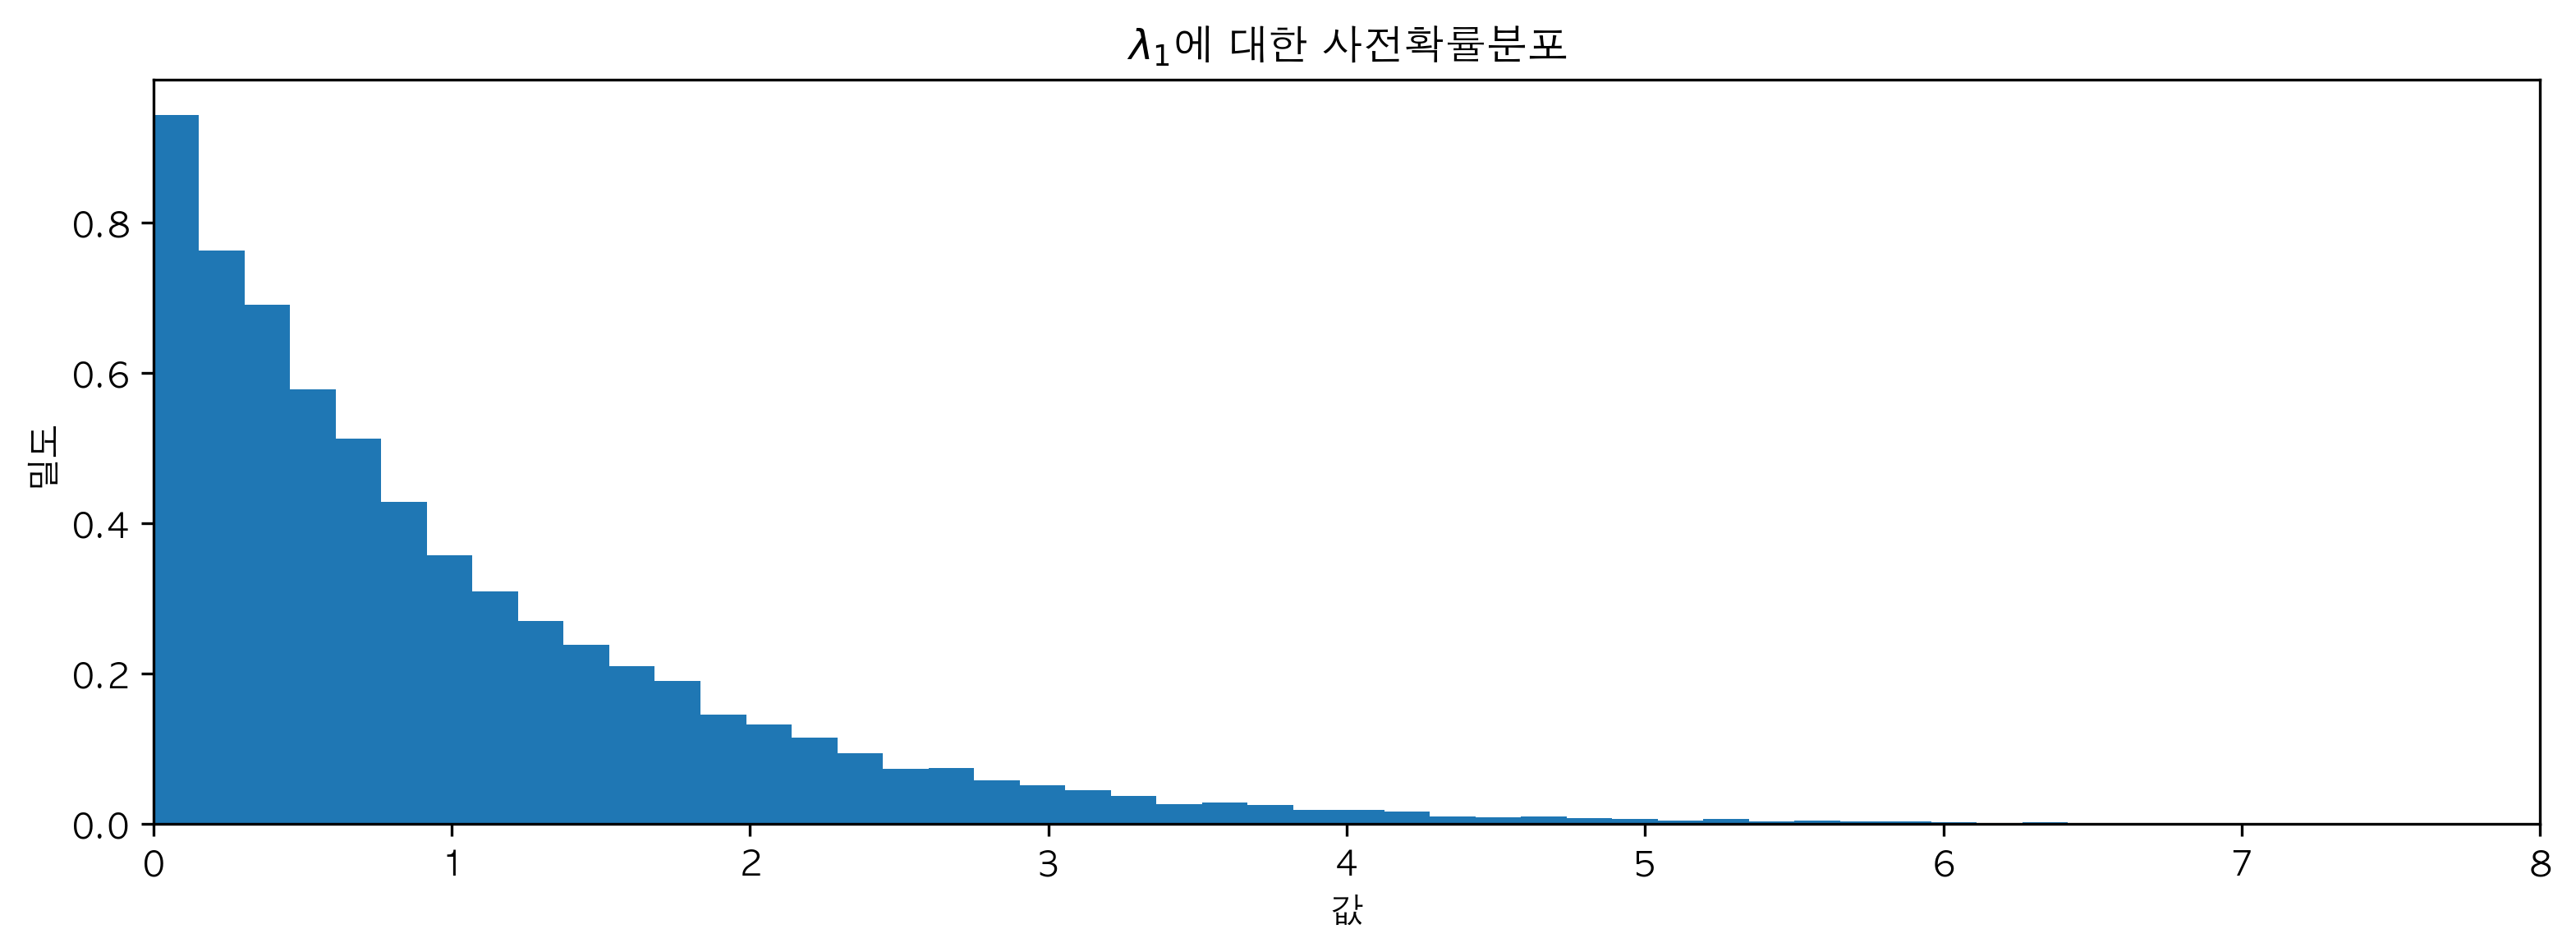

In [11]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

lambda_1 = pm.Exponential("lambda_1", 1)
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title(u'$\lambda_1$에 대한 사전확률분포')
plt.xlabel(u'값')
plt.ylabel(u'밀도')
plt.xlim(0, 8)

데이터/증거/관측치 X를 모델에 포함시는 것

PyMC 확률변수는 boolean을 받는 추가 키워드 인수 observed 를 가진다.

변수 생성 시 초기값을 명시해야하며, 우리가 포함하고자하는 관측값과 같아야 한다.

In [12]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)

print('value:', fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

('value:', array([10,  5]))
calling .random()
('value: ', array([10,  5]))


확률변수가 고정값을 갖도록 초기화

문자 메시지 예제를 완성하려면 PyMC 변수 observation을 관측된 데이터셋에 고정시킨다.

In [13]:
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


### 2.1.4 마지막으로

pm.Model 클래스로 만들어야 한다.

이 Model 클래스를 사용하여 변수를 하나의 단위로 분석할수 있다.

In [14]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])